### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from keras.datasets import mnist

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2022-06-04 11:25:11.465805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 11:25:11.487997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 11:25:11.488176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.1


# Loading and Process of data

In [5]:
#
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# Normalize byte [0,255] -> [0,1]
train_X = train_X / 255.0
test_X = test_X / 255.0

#y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
# Add batch size, since the last dim is not explicity set to 1.
train_X = np.expand_dims(train_X, axis=-1) # <--- add batch axis
test_X = np.expand_dims(test_X, axis=-1) # <--- add batch axis
#
imageShape = train_X[0].shape

In [6]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
print(imageShape)

X_train: (60000, 28, 28, 1)
Y_train: (60000,)
X_test:  (10000, 28, 28, 1)
Y_test:  (10000,)
(28, 28, 1)


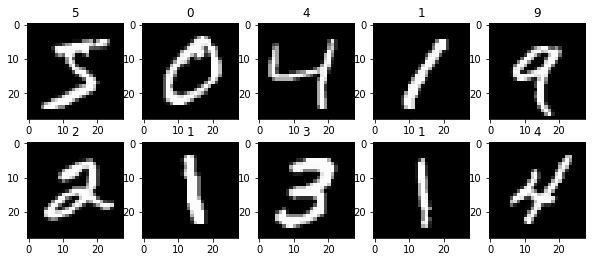

In [7]:
plt.figure(figsize=(10, 4))
nrImage=10
for index, (image, label) in enumerate(zip(train_X[0:nrImage], train_y[0:nrImage])):
	plt.subplot(2, 5, index + 1)
	plt.title(str.format("{0}", label))
	plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
plt.show()

# Common Functions

In [8]:
training_size = len(train_X)
variance = 0.005
varThresh = VarianceThreshold(variance)
high_variance_training_data =  train_X# varThresh.fit(train_X)
high_variance_training_data_size = len(high_variance_training_data)
print(training_size) 
print(high_variance_training_data_size) 

60000
60000


In [9]:
def plotCostHistory(history, loss_label ="", val_label = "", title ="", x_label = "", y_label =""):
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()

# Forward Neuron Network 

In [10]:
def make_forward_neuron_network(shape):
	#
	model = tf.keras.Sequential()
	model.add(layers.Flatten(input_shape=shape)) 
	model.add(layers.Dense(64))
	model.add(layers.Dropout(0.3))
 
	model.add(layers.Dense(96))
	model.add(layers.Dropout(0.3))

	model.add(layers.Dense(96))
	model.add(layers.Dropout(0.3))
	model.add(layers.Dense(10))

	return model

In [11]:
BUFFER_SIZE = 256
BATCH_SIZE = 256
EPOCH = 96

forward_neuron_network_model = make_forward_neuron_network(imageShape)
forward_neuron_network_model.summary()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(1e-4)

forward_neuron_network_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 96)                9312      
                                                                 
 dropout_2 (Dropout)         (None, 96)                0

2022-06-04 11:25:12.393113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-04 11:25:12.394286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 11:25:12.394488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 11:25:12.394603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
checkpoint_filepath_forward_NN = os.path.join("checkpoints", "mnist_forward_neuron_network_ckpt")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_forward_NN,
    save_weights_only=True,
    monitor='accuracy',
    save_freq='epoch',
    mode='max',
    save_best_only=True)

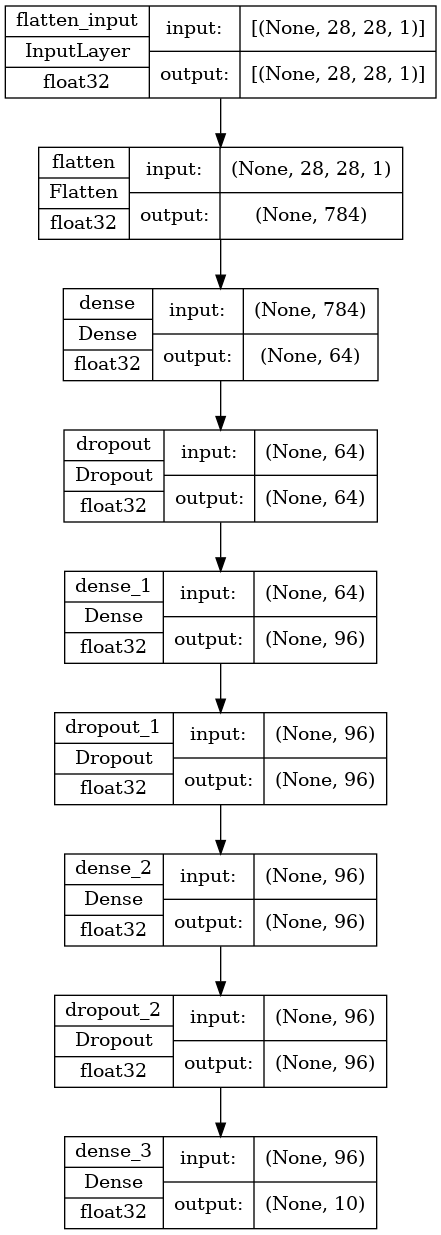

In [13]:
tf.keras.utils.plot_model(
    forward_neuron_network_model, to_file='forward_model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [14]:
forward_nn_history = forward_neuron_network_model.fit(high_variance_training_data, train_y, epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback])
forward_neuron_network_model.load_weights(checkpoint_filepath_forward_NN)

# Save the model for being reuse in other programs and etc.
forward_neuron_network_model.save('fnn_mnist.h5')

Epoch 1/96
 99/235 [===========>..................] - ETA: 0s - loss: 2.0571 - accuracy: 0.2842

2022-06-04 11:25:14.204342: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


235/235 [==============================] - 1s 2ms/step - loss: 1.5472 - accuracy: 0.4848
Epoch 2/96
235/235 [==============================] - 0s 2ms/step - loss: 0.7464 - accuracy: 0.7648
Epoch 3/96
235/235 [==============================] - 0s 2ms/step - loss: 0.5915 - accuracy: 0.8147
Epoch 4/96
235/235 [==============================] - 0s 1ms/step - loss: 0.5314 - accuracy: 0.8394
Epoch 5/96
235/235 [==============================] - 0s 1ms/step - loss: 0.4962 - accuracy: 0.8519
Epoch 6/96
235/235 [==============================] - 0s 2ms/step - loss: 0.4736 - accuracy: 0.8607
Epoch 7/96
235/235 [==============================] - 0s 1ms/step - loss: 0.4581 - accuracy: 0.8645
Epoch 8/96
235/235 [==============================] - 0s 1ms/step - loss: 0.4471 - accuracy: 0.8682
Epoch 9/96
235/235 [==============================] - 0s 1ms/step - loss: 0.4405 - accuracy: 0.8714
Epoch 10/96
235/235 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.8735
Epoch 11/9

In [15]:
forward_neuron_network_model.save('fnn_mnist.h5')

In [16]:
result = forward_neuron_network_model.evaluate(test_X,  test_y, verbose=2)
print(result)

313/313 - 0s - loss: 0.2714 - accuracy: 0.9239 - 300ms/epoch - 957us/step
[0.27138978242874146, 0.9239000082015991]


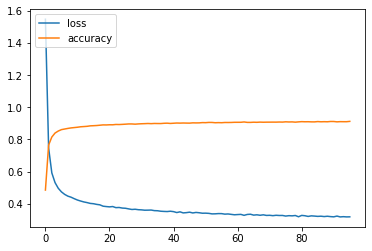

In [17]:
plotCostHistory(forward_nn_history.history)

# Convolution Neuron Network

In [18]:
def make_cnn_model(shape):
	cnn_model = tf.keras.Sequential()
	#
	cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding='same',
							input_shape=shape))
	cnn_model.add(layers.MaxPooling2D((2, 2)))
	#
	cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
	cnn_model.add(layers.MaxPooling2D((2, 2)))
	cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))


	cnn_model.add(layers.Dropout(0.3))

	cnn_model.add(layers.Flatten())
	cnn_model.add(layers.Dense(64, activation='relu'))
	cnn_model.add(layers.Dense(10))
	return cnn_model

In [19]:
BUFFER_SIZE = 256
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(high_variance_training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(1e-4)

cnn_model = make_cnn_model((imageShape[0], imageShape[1], 1))
cnn_model.summary()
cnn_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

checkpoint_filepath = os.path.join("checkpoints", "mnist_convolutional_neuron_network_ckpt")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                           

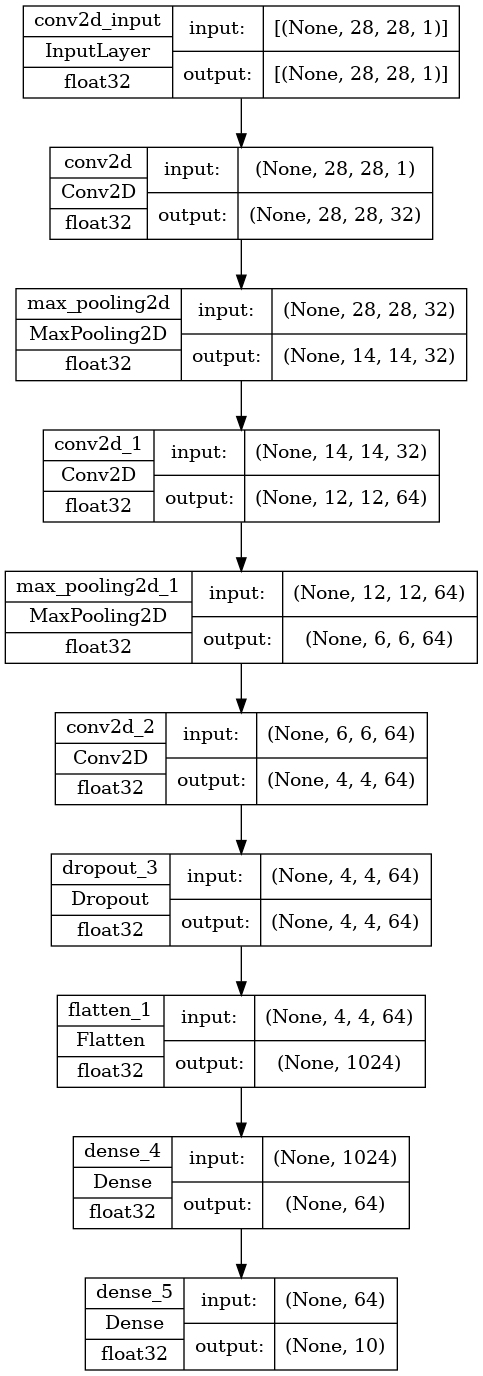

In [20]:
tf.keras.utils.plot_model(
    cnn_model, to_file='cnn_model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [21]:
cnn_model_history = cnn_model.fit(train_X, train_y, epochs=EPOCH, validation_data=(test_X, test_y), callbacks=model_checkpoint_callback)
cnn_model.load_weights(checkpoint_filepath)

Epoch 1/96


2022-06-04 11:25:46.160572: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-06-04 11:25:46.990417: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1875/1875 [==============================] - 5s 2ms/step - loss: 0.4062 - accuracy: 0.8756 - val_loss: 0.1103 - val_accuracy: 0.9658
Epoch 2/96
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1198 - accuracy: 0.9639 - val_loss: 0.0665 - val_accuracy: 0.9785
Epoch 3/96
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0850 - accuracy: 0.9739 - val_loss: 0.0464 - val_accuracy: 0.9857
Epoch 4/96
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0668 - accuracy: 0.9802 - val_loss: 0.0393 - val_accuracy: 0.9870
Epoch 5/96
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0557 - accuracy: 0.9827 - val_loss: 0.0331 - val_accuracy: 0.9897
Epoch 6/96
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0497 - accuracy: 0.9850 - val_loss: 0.0345 - val_accuracy: 0.9882
Epoch 7/96
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0426 - accuracy: 0.9868 - val_loss: 0.0351 - val_accuracy: 0.9874
Epo

In [22]:
cnn_model.save("cnn_mnist.h5")

In [23]:
result = cnn_model.evaluate(test_X,  test_y, verbose=2)
print(result)

313/313 - 0s - loss: 0.0311 - accuracy: 0.9935 - 306ms/epoch - 978us/step
[0.031072482466697693, 0.9934999942779541]


In [24]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 dropout_3 (Dropout)         (None, 4, 4, 64)         

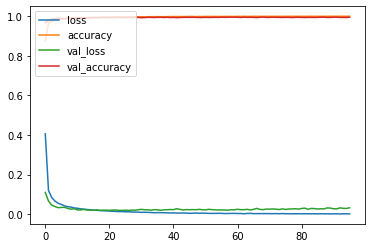

In [25]:
plotCostHistory(cnn_model_history.history)